In [21]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator
sys.path.append(dirname(dirname(realpath(os.getcwd()))))

from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=40)
    return prob_true, prob_pred


def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

def logit (p): return np.log(  p / (1 - p) )
def expit (p): return   np.exp(p)/(1 + np.exp(p))

devpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.dev_preds")

with open(devpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

testpath = os.path.join(src_path ,'logs_transformer_vte/L/12_12/', "68e9a10a80da6c966c226a57b3ccf0fb.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)


tp= np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold0 =   np.array(M_test['golds'],dtype = int)

In [31]:
wts1 = np.where(gold1 == 1, 1/np.mean(gold1), 1)
wts2 = np.where(gold2 == 1, 1/np.mean(gold2), 1)
wts3 = np.where(gold3 == 1, 1/np.mean(gold3), 1)
wts4 = np.where(gold4 == 1, 1/np.mean(gold4), 1)

In [32]:
def temperature_multi_w(l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])  / t[5] 
        logi_2 = (l2 +  t[2])  / t[6] 
        logi_3 = (l3 +  t[3])  / t[7] 
        logi_4 = (l4 +  t[4])  / t[8] 
        
        p1  = expit (t[0]*   logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] *  logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+ log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1, .1,.1, .1,.1  ] )    
    return  r

In [33]:
tt  = temperature_multi_w( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [34]:
def temp_pred  ( j1,j2, test_logit):    
    logi =  ( test_logit   + j1) / j2     
    proba = expit ( tt.x[0] * logi   )  
    return proba

In [35]:
cal_1 = temp_pred(tt.x[1],tt.x[5], logit(tp1) )
cal_2 = temp_pred(tt.x[2],tt.x[6], logit(tp2) )
cal_3 = temp_pred(tt.x[3],tt.x[7], logit(tp3) )
cal_4 = temp_pred(tt.x[4],tt.x[8], logit(tp4) )

In [36]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal_1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal_2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal_3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal_4 )


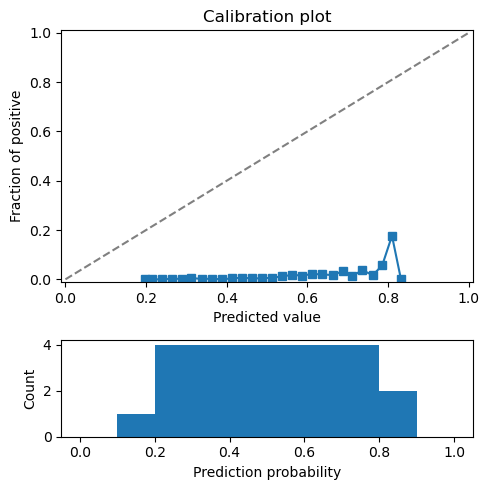

In [37]:
plotter(p4, y4)

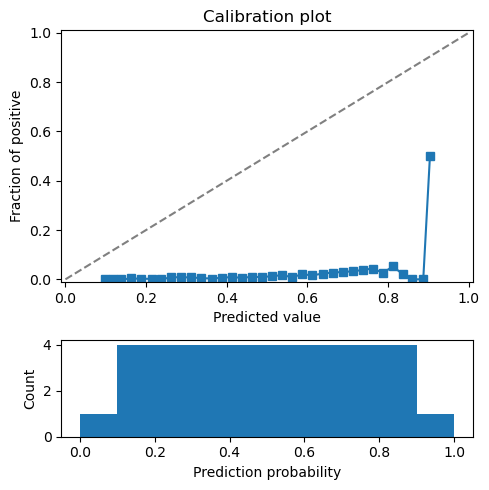

In [38]:
plotter(p3, y3)

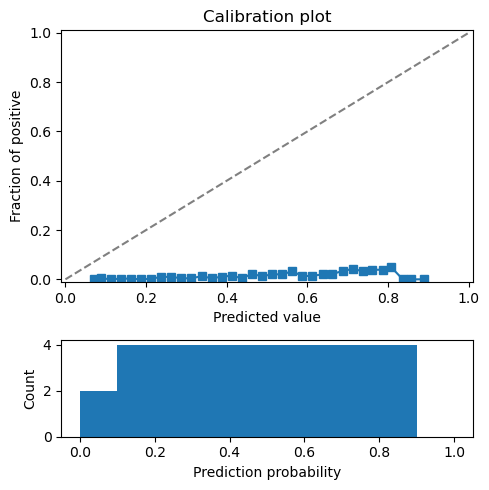

In [39]:
plotter(p2, y2)

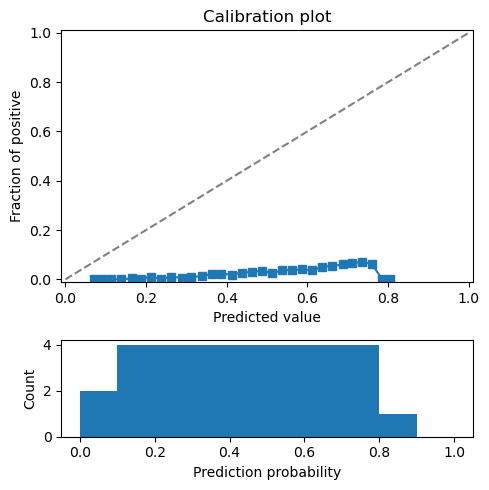

In [40]:
plotter(p1, y1)

In [20]:
import sklearn
from sklearn.metrics import confusion_matrix

In [224]:
sklearn.metrics.roc_auc_score(tgold3,  tc3 , average = 'samples')


0.6854529873329583

In [230]:
sklearn.metrics.roc_auc_score(tgold4,  tc4 , average = 'samples')


0.7072423069302404

In [225]:
sklearn.metrics.roc_auc_score(tgold1,  tc1 , average = 'samples')


0.6480031999535442

In [226]:
( confusion_matrix (tgold1,  tc1>.5) )

array([[8111, 7408],
       [ 145,  361]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [231]:
( confusion_matrix (tgold1,  tp1>.05) )

array([[ 1657, 13862],
       [   10,   496]], dtype=int64)

In [227]:
( confusion_matrix (tgold2,  tc2>.5) )

array([[12250,  1605],
       [  149,    50]], dtype=int64)

In [228]:
( confusion_matrix (tgold3,  tc3>.5) )

array([[12405,    42],
       [  130,     2]], dtype=int64)

In [229]:
( confusion_matrix (tgold4,  tc4>.5) )

array([[10584,   128],
       [   94,     4]], dtype=int64)

In [67]:
def temperature_multi_w5 (l1, l2,l3,l4, y1, y2, y3, y4, w1, w2, w3, w4):
    def temperature_obj(t):
        logi_1 = (l1 +  t[1])  
        logi_2 = (l2 +  t[2])   
        logi_3 = (l3 +  t[3])   
        logi_4 = (l4 +  t[4])  
        
        p1  = expit (t[0]*   logi_1  )  
        p2  = expit ( t[0] *  logi_2  )  
        p3  = expit (t[0] *  logi_3  )  
        p4  = expit ( t[0] *  logi_4  ) 
        total_loss=log_loss(y1,p1,sample_weight=w1)+log_loss(y2,p2,sample_weight=w2)+ log_loss(y3,p3,sample_weight=w3)+log_loss(y4,p4,sample_weight=w4)        
        return   total_loss
    r = minimize (temperature_obj, x0 = [.1, .1, .1,.1, 
                                         .1 ] )    
    return  r

In [68]:
tt  = temperature_multi_w5( logit(mp1), logit(mp2), logit(mp3), logit(mp4),
                          gold1, gold2, gold3, gold4, wts1, wts2, wts3, wts4  )

In [70]:
def temp_pred  ( j1, test_logit):    
    logi =  ( test_logit   + j1)   
    proba = expit ( tt.x[0] * logi   )  
    return proba

In [71]:
cal_1 = temp_pred(tt.x[1] , logit(tp1) )
cal_2 = temp_pred(tt.x[2],  logit(tp2) )
cal_3 = temp_pred(tt.x[3],  logit(tp3) )
cal_4 = temp_pred(tt.x[4],  logit(tp4) )

In [72]:
y1, p1 = compute_calibration_curve(M_test1['golds'], cal_1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], cal_2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], cal_3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], cal_4 )


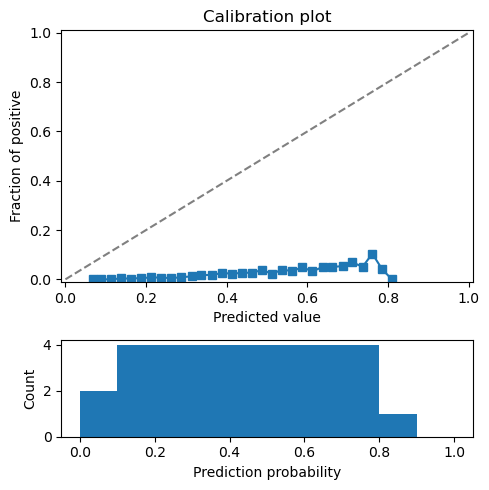

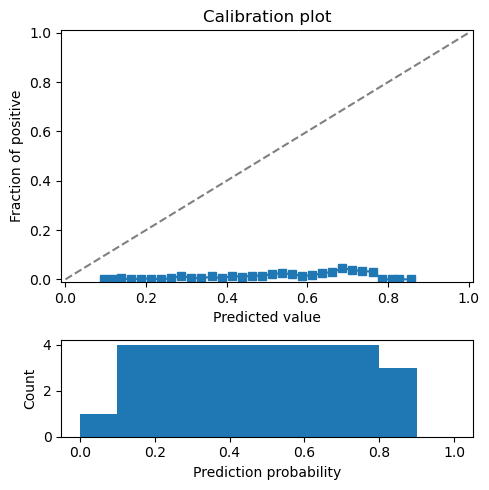

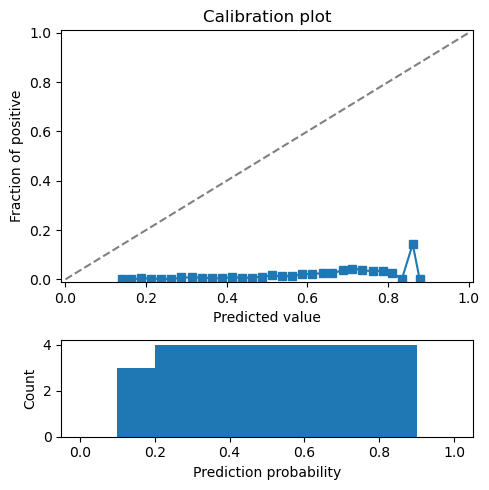

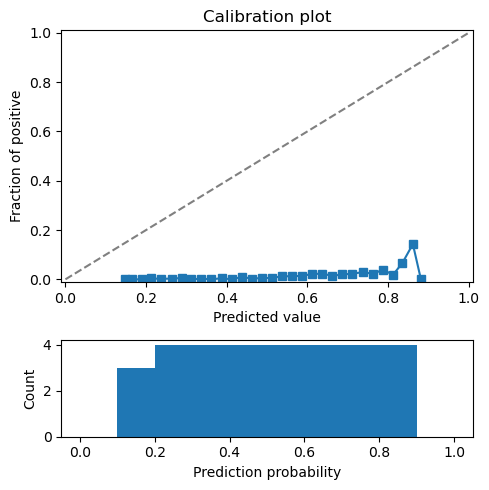

In [73]:
plotter(p1, y1)
plotter(p2, y2)
plotter(p3, y3)
plotter(p4, y4)